# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

Deep Learning for Coders with fastai & PyTorch de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the LICENSE file for details.

In [1]:
from fastai2.vision.all import *

In [47]:
# Utilitaire
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

# Autres problèmes de vision par ordinateur

## Classification multi-label

VOC dataset : http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

### Les données

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Pandas and DataFrames

In [4]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
df1 = pd.DataFrame()
df1['a'] = [1,2,3,4]
df1

,a
0,1
1,2
2,3
3,4


In [7]:
df1['b'] = [10, 20, 30, 40]
df1['a'] + df1['b']

0    11
1    22
2    33
3    44
dtype: int64

### Construire un data block

In [8]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('008639.jpg', 'dog')

In [9]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('000174.jpg', 'person')

In [10]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/storage/data/pascal_2007/train/000767.jpg'), ['cow'])

In [11]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [15]:
catcode = torch.where(dsets.train[0][1]==1.)[0]
catcode

tensor([1])

In [16]:
dsets.train.vocab[catcode]

(#1) ['bicycle']

In [17]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

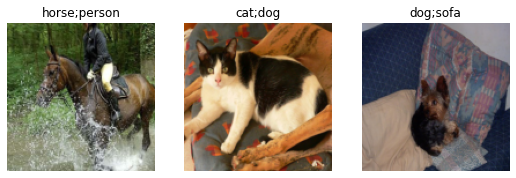

In [19]:
dls.show_batch(nrows=1, ncols=3)

### Binary cross entropy

In [20]:
learn = cnn_learner(dls, resnet18)

Puisqu'on utilise MultiCategoryBlock, fastai va choisir une nouvelle fonction de coût (loss function) automatiquement pour nous : **binary cross entropy**.

In [21]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [22]:
activs[0]

tensor([-0.5077,  1.7623,  0.7657,  0.1416, -1.5309,  1.4160, -1.4559, -2.0791,
        -0.3487,  1.0389, -0.3493,  2.3702,  1.6342, -0.0150, -1.0359, -2.4494,
        -1.4365,  2.0336,  0.0697, -0.5639], device='cuda:0',
       grad_fn=<SelectBackward>)

In [23]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [24]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0361, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

Un changement par rapport à l'exemple précédent est la métrique que nous utilisons : puisque nous sommes dans un problème de multi-label, nous ne pouvons pas utiliser la fonction accuracy. Pourquoi ? Eh bien, la précision consistait à comparer nos résultats à nos objectifs :

```python
def accuracy(inp, targ, axis=-1) :
    "Calculer la précision avec `targ` quand `pred` est bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

La classe prédite était celle qui avait la plus forte activation (c'est ce que fait argmax). Ici, cela ne fonctionne pas parce que nous pourrions avoir plus d'une prédiction sur une seule image. Après avoir appliqué le sigmoïde à nos activations (pour les faire se situer entre 0 et 1), nous devons décider lesquelles sont des 0 et lesquelles sont des 1 en **choisissant un seuil**. Chaque valeur supérieure au seuil sera considérée comme un 1, et chaque valeur inférieure au seuil sera considérée comme un 0 :

```python
def accuracy_multi(inp, targ, thresh=0,5, sigmoid=True) :
    "Calculer la précision lorsque `inp` et `targ` sont de même taille."
    if sigmoid : inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

Si nous passons directement la fonction accuracy_multi comme mesure, elle utilisera la valeur par défaut pour le seuil, qui est de 0,5. Nous pourrions vouloir ajuster cette valeur par défaut et créer une nouvelle version de accuracy_multi qui aurait une valeur par défaut différente. Pour nous aider, il existe une fonction en python appelée partial. Elle nous permet de lier une fonction avec des arguments ou des arguments de mots-clés, en créant une nouvelle version de cette fonction qui, chaque fois qu'elle est appelée, inclut toujours ces arguments.

Par exemple, voici une fonction simple qui prend deux arguments :

In [25]:
def say(name, what): return f"{what} {name}."

say('Jeremy',"Hello")

'Hello Jeremy.'

In [26]:
say_bjr = partial(say, what="Bonjour")

say_bjr("Sylvain")

'Bonjour Sylvain.'

In [27]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.950369,0.704765,0.236514,00:17
1,0.833556,0.569719,0.283904,00:13
2,0.609123,0.203038,0.813765,00:13
3,0.364919,0.123679,0.938128,00:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132051,0.117289,0.939422,00:15
1,0.117974,0.108571,0.952610,00:14
2,0.098471,0.102921,0.950876,00:14


On peut recalculer les performances successivement pour plusieurs valeurs de seuil, mais c'est très long :

In [28]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10292065143585205,0.9303983449935913]

In [29]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10292065143585205,0.9424700736999512]

Une solution plus efficace consiste à calculer une fois pour toutes l'ensemble des activations en sortie du modèle pour tous les éléments du jeu de validation :

In [30]:
preds,targs = learn.get_preds()

Puis à simplement appliquer successivements des seuils différents sur ces activations qui ont été calculées une fois pour toutes :

In [31]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9570)

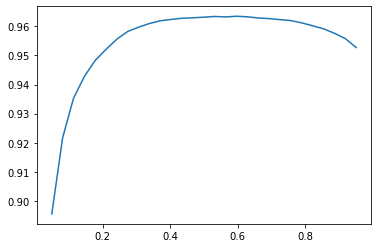

In [32]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

On trouve sur cette courbe la valeur du seuil qui permet d'avoir les meilleures performances.

## Régression

### Assembler les données

In [33]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [34]:
path.ls()

(#50) [Path('/storage/data/biwi_head_pose/16'),Path('/storage/data/biwi_head_pose/10.obj'),Path('/storage/data/biwi_head_pose/03'),Path('/storage/data/biwi_head_pose/16.obj'),Path('/storage/data/biwi_head_pose/19'),Path('/storage/data/biwi_head_pose/01'),Path('/storage/data/biwi_head_pose/20.obj'),Path('/storage/data/biwi_head_pose/13'),Path('/storage/data/biwi_head_pose/05.obj'),Path('/storage/data/biwi_head_pose/21')...]

In [35]:
(path/'01').ls()

(#1000) [Path('/storage/data/biwi_head_pose/01/frame_00182_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00430_pose.txt'),Path('/storage/data/biwi_head_pose/01/frame_00304_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00103_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00091_pose.txt'),Path('/storage/data/biwi_head_pose/01/frame_00409_pose.txt'),Path('/storage/data/biwi_head_pose/01/frame_00239_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00282_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00149_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00375_rgb.jpg')...]

In [36]:
img_files = get_image_files(path)

In [37]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

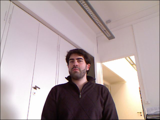

In [38]:
im.to_thumb(160)

In [39]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

pose_file = img2pose(img_files[0])
pose_file

Path('/storage/data/biwi_head_pose/16/frame_00182_pose.txt')

In [40]:
!cat {pose_file}

0.980917 0.0117025 0.194073 
-0.0663273 0.958448 0.27745 
-0.182762 -0.285028 0.940934 

7.83625 21.662 1013.58 



In [41]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_center(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [42]:
get_center(img_files[0])

tensor([324.0023, 251.5637])

In [43]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_center,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

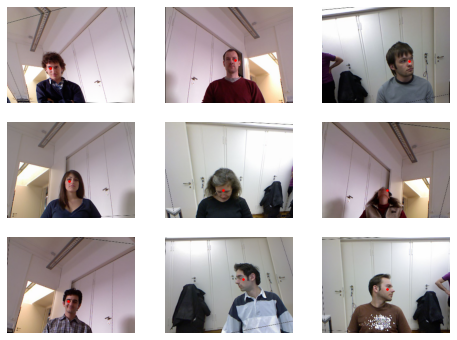

In [44]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [45]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [46]:
yb[0]

tensor([[-0.0963,  0.3147]], device='cuda:0')

### Entrainer un modèle

In [48]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [49]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

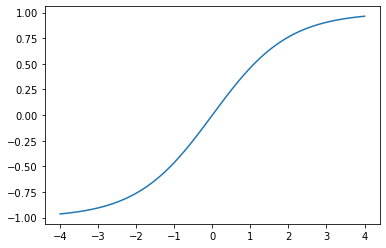

In [50]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [52]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.3182567499825382e-06)

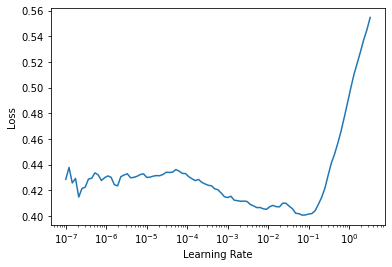

In [53]:
learn.lr_find()

In [54]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.046343,0.053671,00:56
1,0.006745,0.003373,00:54
2,0.003100,0.001718,00:54
3,0.002151,0.001409,00:54
4,0.001636,0.000495,00:54


In [55]:
math.sqrt(0.0001)

0.01

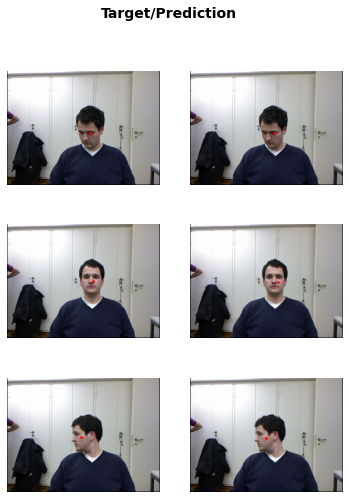

In [60]:
learn.show_results(max_n=9, figsize=(6,8))

# Entrainer un modèle à l'état de l'art

## Imagenette

Nous allons entrainer un modèle à partir de zéro (pas de transfer learning) en utilisant un sous-ensemble d'ImageNet appelé [Imagenette](https://github.com/fastai/imagenette). Il contient dix catégories très différentes du jeu de données original d'ImageNet, ce qui permet un entrainement plus rapide lorsque nous voulons faire des expériences.

Cela va être beaucoup plus difficile à réaliser que nos précédents ensembles de données car nous utilisons des images en couleur et en taille réelle, qui sont des photos d'objets de tailles différentes, dans des orientations différentes, sous des éclairages différents, etc... Dans ce chapitre, nous allons donc présenter quelques techniques importantes pour tirer le meilleur parti de votre ensemble de données, en particulier lorsque vous vous entraînez à partir de zéro ou que vous transférez l'apprentissage vers un ensemble de données très différent de celui utilisé par le modèle pré-entrainé.

In [61]:
path = untar_data(URLs.IMAGENETTE)

In [62]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [63]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.600637,1.619853,0.497760,01:56
1,1.225191,1.435598,0.552651,01:50
2,0.985085,1.590802,0.539208,01:52
3,0.751059,0.709848,0.777072,01:52
4,0.597435,0.543477,0.824122,01:52


## Normalisation

In [123]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4698, 0.4549, 0.4312], device='cuda:0'),
 TensorImage([0.2840, 0.2827, 0.3019], device='cuda:0'))

In [124]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [125]:
dls = get_dls(64, 224)

In [126]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0647,  0.1074,  0.2920], device='cuda:0'),
 TensorImage([1.2203, 1.2017, 1.2924], device='cuda:0'))

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.632865,2.250024,0.391337,01:02
1,1.294041,1.579932,0.517177,01:02
2,0.960535,1.069164,0.657207,01:04
3,0.730220,0.767433,0.771845,01:05
4,0.577889,0.550673,0.824496,01:06


Bien qu'elle n'ait été que peu utile ici, la normalisation devient particulièrement importante lorsqu'on utilise des modèles pré-entrainés. Le modèle pré-entrainé ne sait travailler qu'avec des données du type de celles qu'il a déjà vues. Si le pixel moyen était égal à zéro dans les données avec lesquelles il a été entrainé, mais que vos données ont zéro comme valeur minimale possible d'un pixel, alors le modèle va voir quelque chose de très différent de ce qui est prévu !

Cela signifie que lorsque vous distribuez un modèle, vous devez également distribuer les statistiques utilisées pour la normalisation, puisque toute personne l'utilisant pour l'inférence, ou l'apprentissage par transfert, devra utiliser les mêmes statistiques. De la même manière, si vous utilisez un modèle que quelqu'un d'autre a entrainé, assurez-vous de trouver les statistiques de normalisation qu'il a utilisées et de les faire correspondre.

Nous n'avons pas eu à traiter de la normalisation dans les chapitres précédents parce que lorsque vous utilisez un modèle pré-entrainé via cnn_learner, la bibliothèque fastai ajoute automatiquement la transformation de normalisation appropriée ; le modèle a été pré-entrainé avec certaines statistiques de Normalisation (provenant généralement du jeu de données d'ImageNet), de sorte que la bibliothèque peut les remplir pour vous. Notez que cela ne s'applique qu'aux modèles pré-entrainés, c'est pourquoi nous devons l'ajouter manuellement ici, lors d'un apprentissage à partir de zéro.

## Redimensionnement progressif

Lorsque fast.ai et son équipe d'étudiants ont remporté le concours [DAWNBench](https://www.theverge.com/2018/5/7/17316010/fast-ai-speed-test-stanford-dawnbench-google-intel), l'une des innovations les plus importantes était quelque chose de très simple : commencer l'entrainement en utilisant de petites images, et le terminer en utilisant de grandes images. En passant la plupart des époques d'entrainement avec de petites images, ll'entrainement s'est terminé beaucoup plus rapidement. En terminant l'entrainement à l'aide de grandes images, la précision finale était beaucoup plus élevée. Nous appelons cette approche "redimensionnement progressif".

Jargon : redimensionnement progressif : Utilisation progressive d'images de plus en plus grandes au fur et à mesure de l'entraînement.

Comme nous l'avons vu, les types de caractéristiques qui sont apprises par les réseaux neuronaux convolutifs ne sont en aucun cas spécifiques à la taille de l'image - les premières couches détectent des choses comme des bords et des gradients, et les couches ultérieures peuvent trouver des choses comme des nez et des couchers de soleil. Ainsi, lorsque nous modifions la taille de l'image en cours de formation, cela ne signifie pas que nous devons trouver des paramètres totalement différents pour notre modèle.

Mais il y a clairement des différences entre les petites et les grandes images, donc nous ne devons pas nous attendre à ce que notre modèle continue à fonctionner aussi bien, sans aucun changement. Cela vous rappelle-t-il quelque chose ? Lorsque nous avons développé cette idée, cela nous a rappelé le transfer learning ! Nous essayons de faire en sorte que notre modèle apprenne à faire quelque chose d'un peu différent de ce qu'il a appris à faire auparavant. Par conséquent, nous devrions pouvoir utiliser la méthode fine_tune après avoir redimensionné nos images.

Le redimensionnement progressif présente un avantage supplémentaire : c'est une autre forme d'augmentation des données. Par conséquent, vous devriez vous attendre à une meilleure généralisation de vos modèles qui sont entrainés avec le redimensionnement progressif.

Pour mettre en œuvre le redimensionnement progressif, il est plus pratique de créer d'abord une fonction get_dls qui prend une taille d'image et une taille de batch, et qui renvoie vos DataLoaders :

In [ ]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.902943,2.447006,0.401419,00:30
1,1.315203,1.572992,0.525765,00:30
2,1.001199,0.767886,0.759149,00:30
3,0.765864,0.665562,0.797984,00:30


In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.985213,1.654063,0.565721,01:06


epoch,train_loss,valid_loss,accuracy,time
0,0.706869,0.689622,0.784541,01:07
1,0.739217,0.928541,0.712472,01:07
2,0.629462,0.788906,0.764003,01:07
3,0.491912,0.502622,0.836445,01:06
4,0.414880,0.431332,0.863331,01:06


## Test time augmentation

Une autre solution consiste à ne pas se contenter de centrer le recadrage pour la validation, mais plutôt à sélectionner un certain nombre de zones à recadrer à partir de l'image rectangulaire originale, à faire passer chacune d'entre elles dans notre modèle et à prendre le maximum ou la moyenne des prédictions. En fait, nous pourrions faire cela non seulement pour différents recadrages, mais aussi pour différentes valeurs de tous nos paramètres d'augmentation au moment de l'inférence. C'est ce qu'on appelle test-time-augmentation (TTA).

Jargon : test-time-augmentation (TTA) : lors de l'inférence ou de la validation, créer plusieurs versions de chaque image, en utilisant l'augmentation des données, et ensuite prendre la moyenne ou le maximum des prédictions pour chaque version augmentée de l'image

Selon le jeu de données, cette technique peut permettre une amélioration considérable de la précision. Elle ne modifie en rien le temps nécessaire à l'entrainement, mais elle augmente le temps de validation ou d'inférence du nombre d'images augmentées. Par défaut, le fastai utilisera l'image centrale non agrandie, plus quatre images agrandies de façon aléatoire.

Vous pouvez passer n'importe quel DataLoader à la méthode tta() de fastai ; par défaut, il utilisera votre jeu de validation :

In [ ]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8737863898277283

## Mixup

Mixup, introduit dans le papier de 2017 : [Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412), est une technique d'augmentation des données très puissante qui peut fournir une précision nettement supérieure, surtout lorsque vous n'avez pas beaucoup de données et que vous ne disposez pas d'un modèle pré-entrainé qui a été entrainé sur des données similaires à votre ensemble de données. 

Le document explique : "Alors que l'augmentation des données conduit systématiquement à une meilleure généralisation, la procédure dépend du jeu de données, et nécessite donc l'utilisation de connaissances spécialisées". Par exemple, il est courant de retourner les images dans le cadre de l'augmentation des données, mais faut-il les retourner uniquement horizontalement ou aussi verticalement ? La réponse est que cela dépend de votre jeu de données. En outre, si le fait de retourner les images (par exemple) ne vous permet pas d'augmenter suffisamment les données, vous ne pouvez pas "retourner davantage". Il est utile de disposer de techniques d'augmentation des données qui vous permettent de "composer" ou de "diminuer" la quantité de données à augmenter, afin de voir ce qui fonctionne le mieux pour vous.

Le mélange fonctionne comme suit, pour chaque image :

- Sélectionnez une autre image de votre ensemble de données au hasard
- Choisissez un poids au hasard
- Prenez une moyenne pondérée (en utilisant le poids de l'étape 2) de l'image sélectionnée avec votre image ; ce sera votre variable indépendante
- Prenez une moyenne pondérée (avec le même poids) des étiquettes de cette image avec les étiquettes de votre image ; ce sera votre variable dépendante

En pseudo-code, cela donne (où t est le poids de notre moyenne pondérée) :

```
   image2,target2 = dataset[randint(0,len(dataset)]
   t = random_float(0.5,1.0)
   new_image = t * image1 + (1-t) * image2
   new_target = t * target1 + (1-t) * target2
```

Pour que ça fonctionne, vos labels doivent être one-hot encodés. 

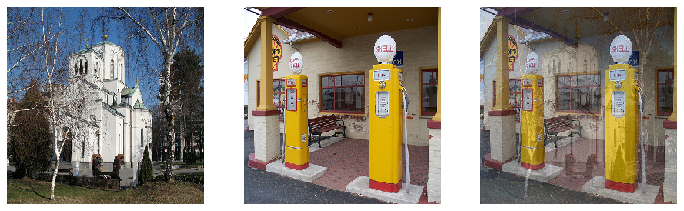

In [ ]:
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

Tout cela est implémenté dans fastai en ajoutant simplement une callback à notre objet Learner. Les callbacks sont utilisées dans fastai pour injecter un comportement personnalisé dans la boucle d'entrainement. Nous apprendrons tout ce qu'il faut savoir sur les callbacks dans une prochaine leçon.

Voici comment on entraine un modèle avec Mixup :

```
   model = xresnet50()
   learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                   metrics=accuracy, cbs=Mixup)
   learn.fit_one_cycle(5, 3e-3)
```

Que se passe-t-il lorsque nous entrainons un modèle dans lequel nos données sont "mélangées" de cette manière ? Il est clair que ce sera plus difficile à entraîner, car il est plus difficile de voir ce qu'il y a dans chaque image. Et le modèle doit prédire deux étiquettes par image, plutôt qu'une seule, et déterminer la pondération de chacune d'entre elles. L'overfitting semble être moins problématique, car nous ne montrons pas la même image à chaque époque, mais plutôt une combinaison aléatoire de deux images.

Le mélange nécessite beaucoup plus d'époques pour obtenir une meilleure précision, comparé aux autres approches d'augmentation que nous avons vues. Vous pouvez essayer d'entraîner Imagenette avec et sans Mixup en utilisant le script examples/train_imagenette.py dans le repo fastai. 

Au moment où nous écrivons ces lignes, le tableau des meilleurs résultats sur Imagenette montre que Mixup est utilisé pour tous les résultats des entrainements sur plus de 80 époques, et que pour un faible nombre d'époques, Mixup n'est pas utilisée. Ceci est conforme à notre expérience de l'utilisation de Mixup également.

## Label smoothing

Dans l'expression théorique de la fonction de coût, pour les problèmes de classification, nos labels sont encodés au format one-hot. Cela signifie que le modèle est entraîné à renvoyer 0 pour toutes les catégories sauf une, pour laquelle il est entraîné à renvoyer 1. Même 0,999 n'est pas suffisant, le modèle obtiendra des gradients et apprendra à prédire des activations encore plus sûres. Cela encourage le sur-ajustement et vous donne au moment de l'inférence un modèle qui ne va pas donner de probabilités significatives : il dira toujours 1 pour la catégorie prédite même si elle n'est pas trop sûre, simplement parce qu'il a été entrainé de cette façon.

Cela peut devenir très dommageable si vos données ne sont pas parfaitement étiquetées.

Au lieu de cela, nous pourrions remplacer tous nos 1 par un nombre un peu inférieur à 1, et nos 0 par un nombre un peu supérieur à 0. C'est ce qu'on appelle le "label smoothing". En encourageant votre modèle à être moins confiant, le "label smoothing" rendra votre entrainement plus robuste, même si les données sont mal étiquetées, et produira un modèle qui généralisera mieux à l'inférence.

Voici comment fonctionne le label smoothing en pratique : nous commençons par des étiquettes encodées au format one-hot, puis nous remplaçons tous les zéros par $\frac{\epsilon}{N}$ où $N$ est le nombre de classes et $\epsilon$ est un paramètre (généralement 0.1, ce qui signifierait que nous sommes à 10% incertains de nos étiquettes). Puisque vous voulez que les étiquettes s'additionnent à 1, remplacez le 1 par $1-\epsilon + \frac{\epsilon}{N}$. 

De cette façon, nous n'encourageons pas le modèle à prédire quelque chose de trop sûr de soi : dans notre exemple Imagenette où nous avons 10 classes, les cibles deviennent quelque chose comme :

[0.01, 0.01, 0.01, 0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

Pour l'utiliser en pratique, il suffit de modifier la fonction de coût dans notre appel à Learner :

```
   model = xresnet50()
   learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                   metrics=accuracy)
   learn.fit_one_cycle(5, 3e-3)
```

Comme pour Mixup, vous ne verrez généralement pas d'améliorations significatives du label smoothing avant d'avoir entrainé sur un grand nombre d'époques.